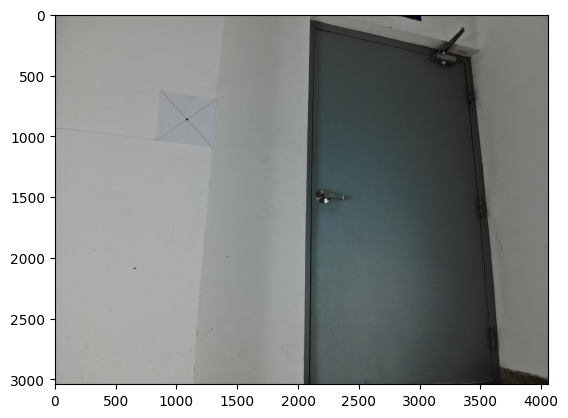

In [10]:
#Codigo que habia en matlab

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Polygon

# Lectura de la imagen RGB
I1 = np.array(Image.open('imagen_rgb4.JPG'))

# Mostrar la imagen RGB
plt.imshow(I1)
plt.show()



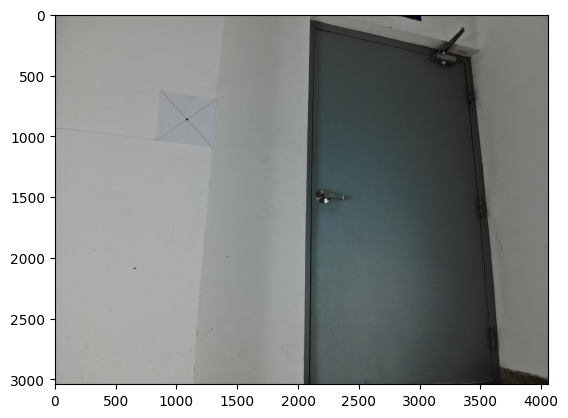

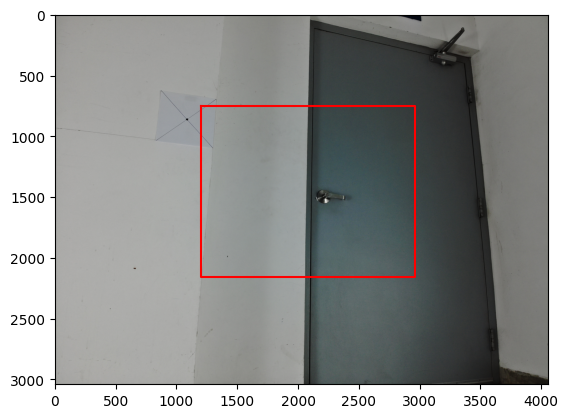

Dimensiones de la imagen: 4056 x 3040


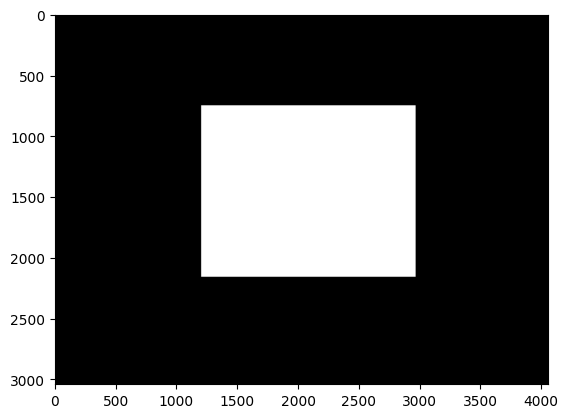

True

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Lectura de la imagen RGB
I1 = cv2.imread('imagen_rgb4.JPG')
I2 = I1.astype(float)
plt.imshow(cv2.cvtColor(I1, cv2.COLOR_BGR2RGB))
plt.show()

# Dibujar un polígono para ubicar la imagen térmica
#x = 55
x = 26
y = -100

#Evaluar el posicinamiento
vertices = np.array([[1200, 776-x], [1200 , 2184-x], [2960, 2184-x ], [2960, 776-x], [1200, 776-x]])  # Cerrar el polígono


plt.imshow(cv2.cvtColor(I1, cv2.COLOR_BGR2RGB))
plt.plot(vertices[:, 0], vertices[:, 1], 'r-')
plt.show()



# Crear una máscara de borde negro y fondo blanco
mask = np.zeros(I1.shape[:2], dtype=np.uint8)
cv2.fillPoly(mask, [vertices], 255)
plt.imshow(mask, cmap='gray')
# Obtiene las dimensiones de la imagen (alto x ancho)
alto, ancho = mask.shape[:2]
print("Dimensiones de la imagen: {} x {}".format(ancho, alto))
plt.show()

# Guardar la máscara como imagen JPG
cv2.imwrite('mask.jpg', mask)


Dimensiones de la imagen: 4056 x 3040


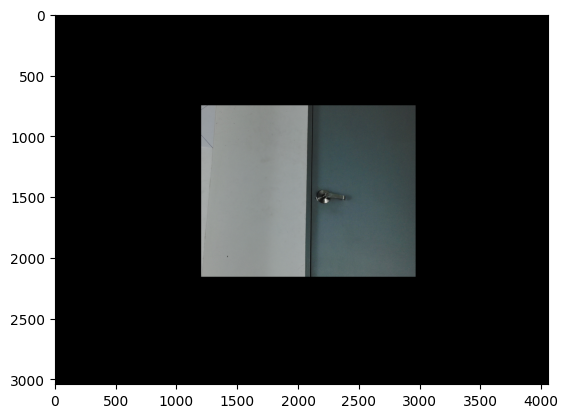

Dimensiones de la imagen: 1759 x 1406


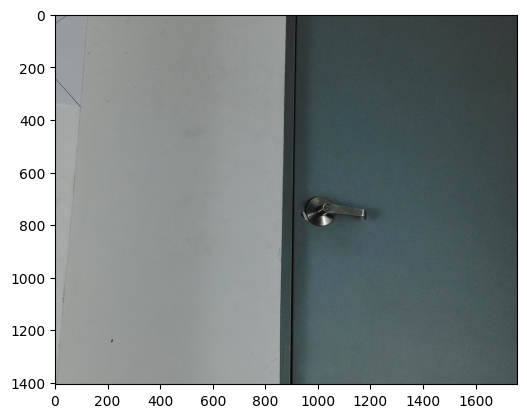

True

In [12]:
#Ahora procesdemos con poner la foto de la imagen rgb en el fondo negro
# Poner la foto de la imagen RGB en el fondo negro
I2_masked = I2.copy()
I2_masked[:, :, 0] *= mask / 255
I2_masked[:, :, 1] *= mask / 255
I2_masked[:, :, 2] *= mask / 255
I2_masked = I2_masked.astype(np.uint8)

# Mostrar la imagen con el fondo recortado
plt.imshow(cv2.cvtColor(I2_masked, cv2.COLOR_BGR2RGB))
# Obtiene las dimensiones de la imagen (alto x ancho)
alto1, ancho1 = I2_masked.shape[:2]
print("Dimensiones de la imagen: {} x {}".format(ancho1, alto1))
plt.show()

# Guardar la imagen con el fondo recortado
cv2.imwrite('fonfo_recorte.jpg', cv2.cvtColor(I2_masked, cv2.COLOR_BGR2RGB))


# Recortar una región de la imagen
#prueba de moficiacion de recorte de imagen
J = I2_masked[750:750+1406, 1200:1200+1759]

# Mostrar la imagen recortada
plt.imshow(cv2.cvtColor(J, cv2.COLOR_BGR2RGB))
# Obtiene las dimensiones de la imagen (alto x ancho)
alto2, ancho2 = J.shape[:2]
print("Dimensiones de la imagen: {} x {}".format(ancho2, alto2))
plt.show()

# Guardar la imagen recortada
cv2.imwrite('imagen_recortada.jpg', cv2.cvtColor(J, cv2.COLOR_BGR2RGB))









In [60]:
#Prueba por Transformada Discreta de Wavelet (DWT)

import numpy as np
import cv2
from skimage import io, color, exposure
import matplotlib.pyplot as plt
import numpy as np
import pywt
from PIL import Image



def imgfusion(Im1, Im2, ftype, wtype):
    # Convertir imágenes a float y realizar la descomposición de wavelet de nivel 1
    coeffs1 = pywt.dwt2(Im1.astype(float), wtype, 'periodization')
    coeffs2 = pywt.dwt2(Im2.astype(float), wtype, 'periodization')
    
    # Extraer las sub-bandas de aproximación y detalle
    cA1, (cH1, cV1, cD1) = coeffs1
    cA2, (cH2, cV2, cD2) = coeffs2
    
    # Preparar matrices de coeficientes para la imagen resultante
    cA = np.zeros_like(cA1)
    cH = np.zeros_like(cH1)
    cV = np.zeros_like(cV1)
    cD = np.zeros_like(cD1)

    # Procesar según el tipo de fusión especificado
    for i in range(cA1.shape[0]):
        for k in range(cA1.shape[1]):
            if ftype == 'MeanMean':
                cA[i, k] = np.mean([cA1[i, k], cA2[i, k]])
                cH[i, k] = np.mean([cH1[i, k], cH2[i, k]])
                cV[i, k] = np.mean([cV1[i, k], cV2[i, k]])
                cD[i, k] = np.mean([cD1[i, k], cD2[i, k]])
            # Repetir estructura similar para otros casos como 'MeanMax', 'MaxMean', etc.
        
    # Usar todas las combinaciones de fusión como se define en MATLAB
            elif ftype == 'MeanMax':
                cA[i, k] = np.mean([cA1[i, k], cA2[i, k]])
                cH[i, k] = np.max([cH1[i, k], cH2[i, k]])
                cV[i, k] = np.max([cV1[i, k], cV2[i, k]])
                cD[i, k] = np.max([cD1[i, k], cD2[i, k]])
            # Continuar con otras condiciones...

    # Reconstruir la imagen fusionada usando los coeficientes fusionados
    outimage = pywt.idwt2((cA, (cH, cV, cD)), wtype, 'periodization')
    return outimage




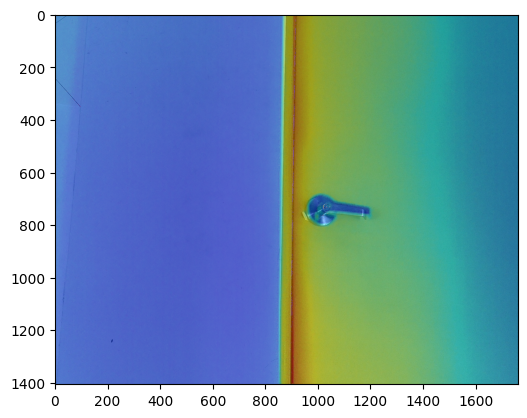

In [67]:
# Fusión de imágenes mediante la transformada de wavelet

fusiontype = 'MeanMax'
wavetype = 'coif5'

# Cargar la imagen recortada anterior J
img1 = np.array(Image.open('imagen_recortada.jpg'))

# Cargar la imagen térmica
img2 = np.array(Image.open('imagen_termica4.JPG'))

# Asegurar que img2 tenga el mismo tamaño que img1
if img1.shape != img2.shape:
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

# Obtener las dimensiones de la imagen recortada
row, col, _ = img1.shape

# Fusionar las imágenes canal por canal utilizando la función imgfusion
fusedimageR = imgfusion(img1[:, :, 0], img2[:, :, 0], fusiontype, wavetype)
fusedimageG = imgfusion(img1[:, :, 1], img2[:, :, 1], fusiontype, wavetype)
fusedimageB = imgfusion(img1[:, :, 2], img2[:, :, 2], fusiontype, wavetype)

# Combinar los canales fusionados en una sola imagen
fusedimage = np.uint8(np.stack([fusedimageR, fusedimageG, fusedimageB], axis=-1))

# Guardar y mostrar la imagen fusionada
Image.fromarray(fusedimage).save('FUSION1.jpg', quality=100)
plt.imshow(fusedimage)
plt.show()

#ERROR CON LA TRANSFORMADA DE WAVELET:
# ValueError: not enough values to unpack (expected 4, got 2)



In [62]:
#Superposicion final, para visualizarse en la imagen total:

# Leer las imágenes
imageT = Image.open('FUSION1.jpg')  
imageW = Image.open('imagen_rgb17.JPG')

# Redimensionar imageT (opcional)
# imageT = imageT.resize(imageW.size)

# Obtener las dimensiones de imageT
ancho_p, alto_p = imageT.size

# Convertir las imágenes a matrices NumPy
imageT_np = np.array(imageT)
imageW_np = np.array(imageW)

# Iterar sobre los píxeles de imageT
for x in range(ancho_p):
    for y in range(alto_p):
        pixel_imageT = imageT_np[y, x]
        
        # Verificar si el píxel de imageT no es negro (valor != 0)
        if (pixel_imageT != 0).any():
            # Asignar el valor del píxel de imageT a la imagen imageW en escala de grises
            imageW_np[y+726, x+1113] = pixel_imageT


# Mostrar la imagen resultante
imagen_fusionada = Image.fromarray(imageW_np)
imagen_fusionada.show()  # Mostrar la imagen resultante
imagen_fusionada.save('imagen_fusionada.jpg')  # Guardar la imagen resultante





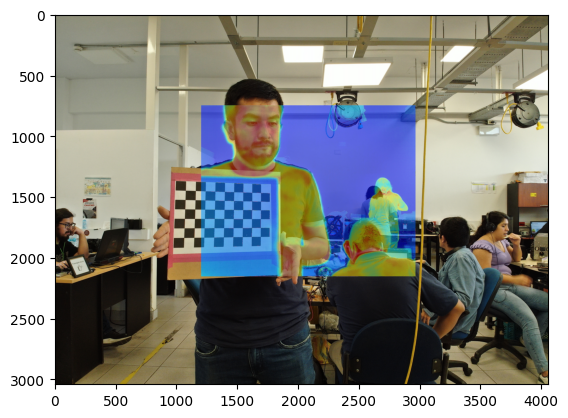

In [6]:
#SE ANALIZARA DESPUES:
import os
from PIL import Image
#Codigo en caso las imagenes sean de color y tengan los 3 canales: 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Polygon


# Leer las imágenes
imageT = Image.open('FUSION_DWT_1.JPG')
imageW = Image.open('imagen_rgb_1.JPG')

# Cambiar el tamaño de la imagen fusionada (opcional)
# imageT = imageT.resize(imageW.size)

# Obtener las dimensiones de la imagen fusionada
ancho_p, alto_p = imageT.size

# Obtener las capas de color de la imagen fusionada
capa_r_imageT, capa_g_imageT, capa_b_imageT = imageT.split()

# Convertir las imágenes a matrices NumPy
imageW_np = np.array(imageW)
capa_r_imageT_np = np.array(capa_r_imageT)
capa_g_imageT_np = np.array(capa_g_imageT)
capa_b_imageT_np = np.array(capa_b_imageT)

# Iterar sobre los píxeles de la imagen fusionada
for x in range(ancho_p):
    for y in range(alto_p):
        pixel_r_imageT = capa_r_imageT_np[y, x]
        pixel_g_imageT = capa_g_imageT_np[y, x]
        pixel_b_imageT = capa_b_imageT_np[y, x]
        
        # Comprobar si el píxel de la imagen fusionada no es negro
        if pixel_r_imageT != 0 and pixel_g_imageT != 0 and pixel_b_imageT != 0:
            # Asignar los valores de píxeles de la imagen fusionada a la imagen original
            imageW_np[y+750, x+1200, 0] = pixel_r_imageT
            imageW_np[y+750, x+1200, 1] = pixel_g_imageT
            imageW_np[y+750, x+1200, 2] = pixel_b_imageT

# Mostrar la imagen resultante
plt.figure()
plt.imshow(imageW_np)
plt.show()


